In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
import itertools
import umap

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from importlib import reload

# local imports
# sys.path.append("../")
import utils as ut

2024-02-14 06:55:01.976141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 06:55:08.560216: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-14 06:55:12.560995: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 06:55:41.479357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

In [2]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

# load the GTF file 

In [3]:
gtf_path = "/scratch/indikar_root/indikar1/cstansbu/HSC/references/geneTable.csv"

gdf = pd.read_csv(gtf_path)
print(f"{gdf.shape=}")
gdf.head()

/tmp/ipykernel_2351817/3113241625.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdf = pd.read_csv(gtf_path)


gdf.shape=(3371244, 26)


,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_version,...,transcript_source,transcript_biotype,tag,ccds_id,exon_number,exon_id,exon_version,protein_id,protein_version,transcript_support_level
0,1,ensembl_havana,gene,1471764,1497848,.,+,.,ENSG00000160072,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ensembl_havana,transcript,1471764,1497848,.,+,.,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,NaN,NaN,NaN,NaN,NaN,NaN
2,1,ensembl_havana,exon,1471764,1472089,.,+,.,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,ENSE00003889014,1.0,NaN,NaN,NaN
3,1,ensembl_havana,CDS,1471884,1472089,.,+,0,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,NaN,NaN,ENSP00000500094,1.0,NaN
4,1,ensembl_havana,start_codon,1471884,1471887,.,+,0,ENSG00000160072,20,...,ensembl_havana,protein_coding,basic,CCDS30,1.0,NaN,NaN,NaN,NaN,NaN


# Load our data

In [4]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.tabula.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

In [5]:
adata.var_names_make_unique()

# annotate all labels
adata.obs['group'] = np.where(adata.obs['cluster_name'].isna(), "C5", adata.obs['cluster_name'])
adata.obs['group'] = np.where(adata.obs['celltype'] == 'HSC', "C6", adata.obs['group'])

# prepare data

In [171]:
# prepare sample
pdf = ut.get_stacked_cell_data(adata, genes=None)
label_map = {
    'C1' : "iHSC",
    'C2' : "iHSC",
    'C3' : "iHSC",
    'C4' : "iHSC",
    'C5' : "Fibroblast",
    'C6' : "HSC",
}
pdf.obs['label'] = pdf.obs['group'].map(label_map)

pdf

AnnData object with n_obs × n_vars = 16968 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group', 'label'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

# Compare expression of our cells to ref fib

In [172]:
genes = pdf.var[pdf.var['is_fb_marker'] | pdf.var['is_hsc_marker']]['gene_symbol'].index

# for labelling
hsc_genes = pdf.var[pdf.var['is_hsc_marker']].index

layer = 'log_tpm'
counts = pdf[:, genes].to_df(layer=layer)
counts['label'] = pdf.obs['label']
counts = counts.groupby('label').agg('mean').T
counts = counts.reset_index(drop=False)

counts['marker_type'] = np.where(counts['gene_name'].isin(hsc_genes), 'HSC', 'FB')

counts.head()

label,gene_name,Fibroblast,HSC,iHSC,marker_type
0,TNFRSF1B,0.720560,0.552654,1.098240,FB
1,PRRX1,4.493501,0.001801,0.030630,FB
2,RGS18,0.016995,1.535963,0.313491,HSC
3,TGFB2,0.354470,0.013854,0.031797,HSC
4,PRG4,1.308378,0.029387,0.150492,FB


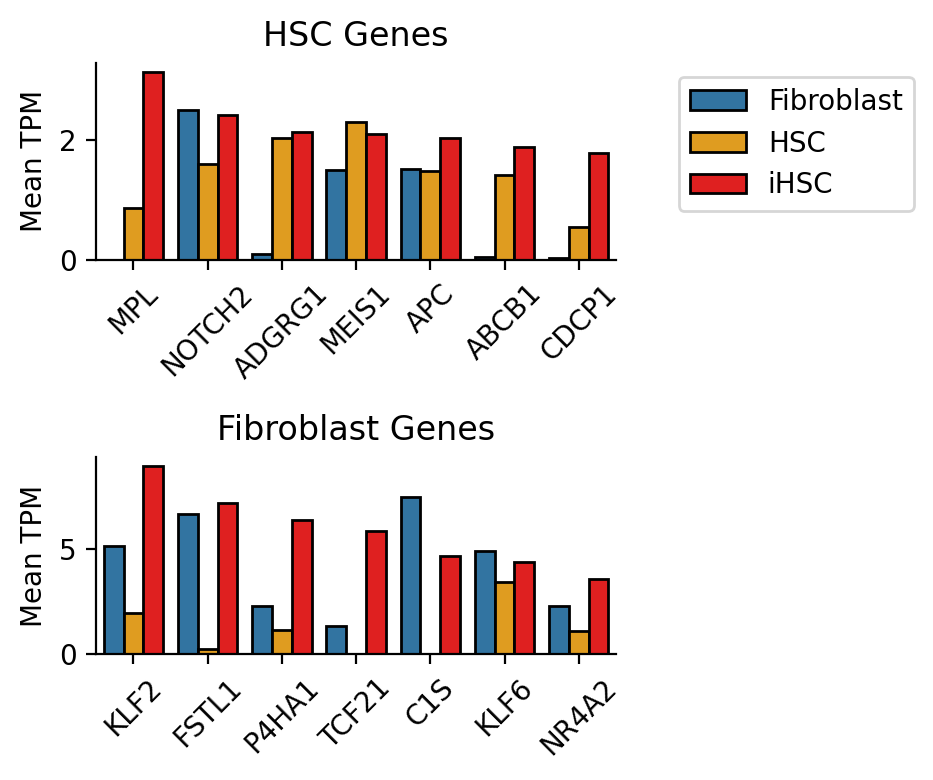

In [173]:
# plot HSC markers
n_plot = 7

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4
fig, axs = plt.subplots(2, 1)

titles = {
    'HSC' : 'HSC Genes',
    'FB' : 'Fibroblast Genes',
}

for i, ct in enumerate(['HSC', 'FB']):
    
    pdx = counts[counts['marker_type'] == ct]
    pdx = pdx.sort_values(by='iHSC', ascending=False)
    pdx = pdx.head(n_plot)
    pdx = pd.melt(pdx, id_vars=['gene_name', 'marker_type'])


    sns.barplot(data=pdx, 
                x='gene_name',
                y='value',
                hue='label',
                palette=['C0', 'orange', 'r'],
                ec='k',
                ax=axs[i],
               )

    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_xlabel("")
    axs[i].set_title(titles[ct])
    axs[i].set_ylabel('Mean TPM')

    if i == 0:
        sns.move_legend(axs[i], 
                        loc='upper right',
                        bbox_to_anchor=(1.6, 1),
                        title="")
    else:
        axs[i].legend().remove()

plt.tight_layout()
sns.despine()


# Get gene set

In [275]:
genes = pdf.var[pdf.var['is_hsc_marker'] | pdf.var['is_fb_marker']]
outpath = f"/nfs/turbo/umms-indikar/shared/projects/HSC/data/isoforms/marker_genes.csv"

genes.to_csv(outpath, index=False)
genes.head()

,gene_id,gene_symbol,is_fb_marker,is_hsc_marker
gene_name,,,,
TNFRSF1B,ENSG00000028137,TNFRSF1B,True,False
PRRX1,ENSG00000116132,PRRX1,True,False
RGS18,ENSG00000150681,RGS18,False,True
TGFB2,ENSG00000092969,TGFB2,False,True
PRG4,ENSG00000116690,PRG4,True,False


genes.shape=(206,)


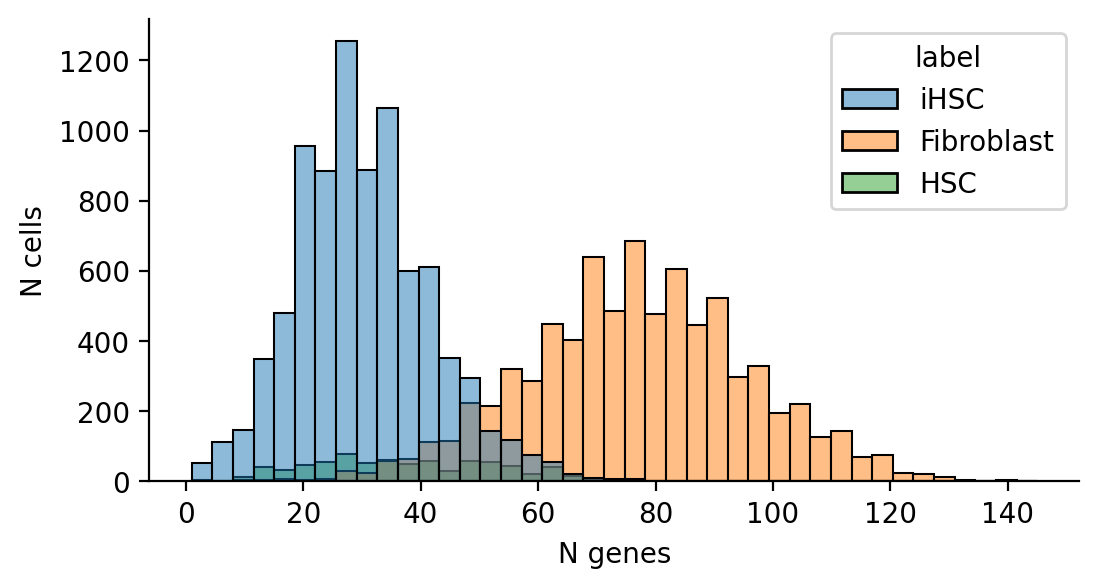

In [175]:
# filter cells
# genes = pdf.var[pdf.var['is_hsc_marker']]['gene_symbol'].index
genes = pdf.var[pdf.var['is_hsc_marker'] | pdf.var['is_fb_marker']]['gene_symbol'].index
print(f"{genes.shape=}")

# extract a layer
layer = 'raw_counts'
X = pdf[:, genes].to_df(layer=layer)
X = X.astype(bool)
n_genes = X.sum(axis=1)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
sns.histplot(x=n_genes,
             hue=pdf.obs['label'])

plt.ylabel('N cells')
plt.xlabel('N genes')
sns.despine()

genes.shape=(206,)


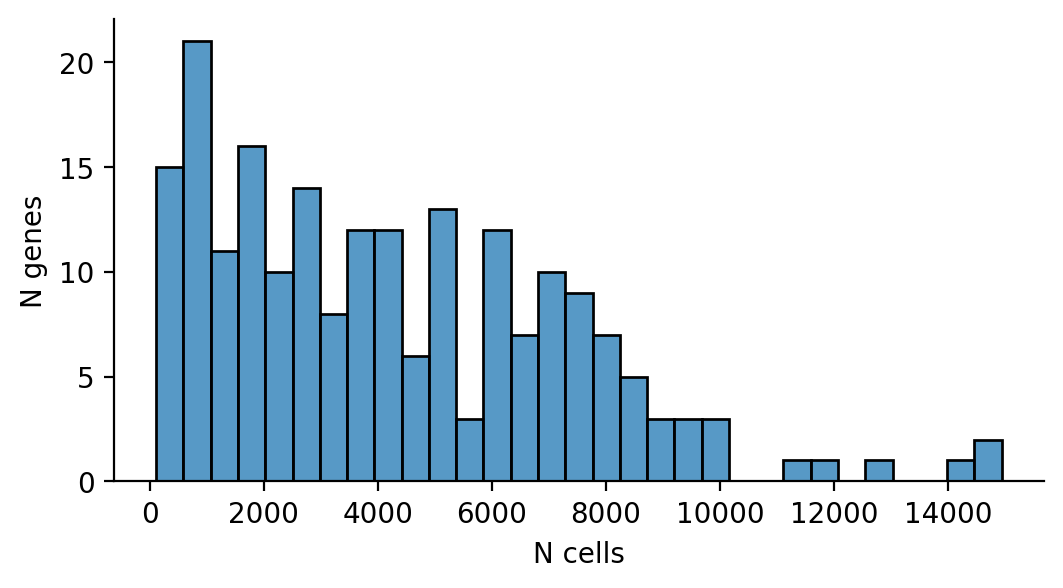

In [176]:
# are there genes that we need to drop?

# genes = pdf.var[pdf.var['is_hsc_marker']]['gene_symbol'].index
genes = pdf.var[pdf.var['is_hsc_marker'] | pdf.var['is_fb_marker']]['gene_symbol'].index
print(f"{genes.shape=}")

# extract a layer
layer = 'raw_counts'
X = pdf[:, genes].to_df(layer=layer)
X = X.astype(bool)

n_cells = X.sum(axis=0)
n_cells = n_cells.sort_values()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3
sns.histplot(x=n_cells,
             bins=31)

plt.xlabel('N cells')
plt.ylabel('N genes')
sns.despine()

In [177]:
pdf

AnnData object with n_obs × n_vars = 16968 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group', 'label'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

genes.shape=(194,)
X.shape=(16968, 194) X_scaled.shape=(16968, 194)
embedding.shape=(16968, 2)


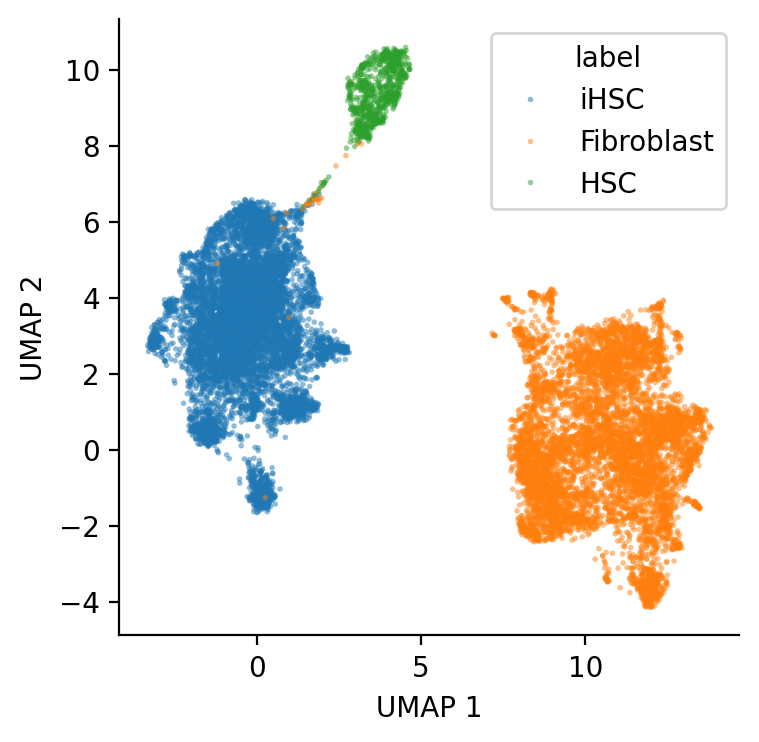

In [218]:
# genes = pdf.var[pdf.var['is_hsc_marker']]['gene_symbol'].index
genes = pdf.var[pdf.var['is_hsc_marker'] | pdf.var['is_fb_marker']]['gene_symbol'].index

# get the number of cells expressing each gene
layer = 'raw_counts'
X = pdf[:, genes].to_df(layer=layer)
X = X.astype(bool)

# filter out genes not expressed in at least 1000 cells
THRESHOLD = 500
n_cells = X.sum(axis=0)
genes = n_cells[n_cells > THRESHOLD].index
print(f"{genes.shape=}")

# extract a layer - notice that it's not the raw counts! (different read depths)
layer = 'log_tpm'
X = pdf[:, genes].to_df(layer=layer)

X_scaled = preprocessing.StandardScaler().fit_transform(X)
print(f"{X.shape=} {X_scaled.shape=}")

# n_neighbors = 51
n_neighbors = 5
min_dist = 0.2
n_components = 2
metric = 'euclidean'

reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    metric=metric,
)

embedding = reducer.fit_transform(X_scaled)
print(f"{embedding.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=pdf.obs, 
                x=embedding[:, 0],
                y=embedding[:, 1],
                hue='label',
                ec='none',
                alpha=0.5,
                s=4,
               )

plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
sns.despine()

# clean plot

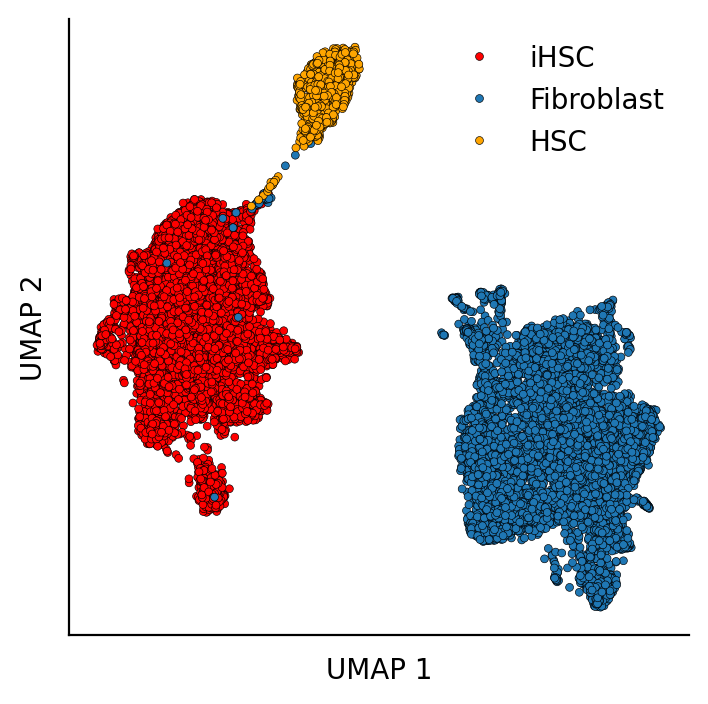

In [220]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=pdf.obs, 
                x=embedding[:, 0],
                y=embedding[:, 1],
                hue='label',
                palette=['r', 'C0', 'orange',],
                alpha=1.0,
                ec='k',
                s=8,
               )

plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

sns.move_legend(plt.gca(),
                loc='upper right',
                frameon=False,
                title="")
sns.despine()

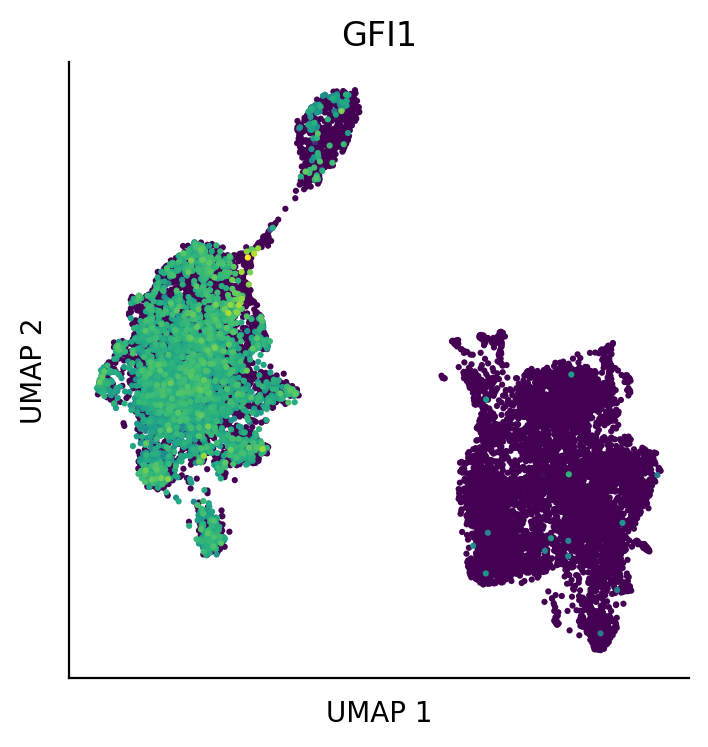

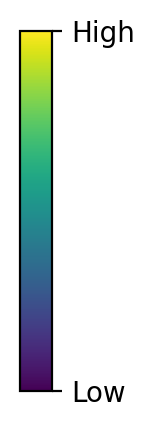

In [272]:

gene = 'GFI1'
cmap = 'viridis'
pdx = pdf.obs.copy()
pdx[gene] = pdf[:, gene].to_df(layer='log_tpm')

pdx['UMAP 1'] = embedding[:, 0]
pdx['UMAP 2'] = embedding[:, 1]

order_idx = np.argsort(pdx[gene])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=pdx.iloc[order_idx], 
               x='UMAP 1',
               y='UMAP 2',
               palette=cmap,
               ec='none',
               s=5,
               hue=gene)

plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
plt.title(gene)
plt.gca().legend().remove()
sns.despine()

ut.makeColorbar(cmap, 0.2, 3, '', 'vertical', ['Low', 'High'])


In [244]:
counts = counts.sort_values(by='HSC', ascending=False)
counts.head(30)

label,gene_name,Fibroblast,HSC,iHSC,marker_type
20,TXNIP,6.804565,5.988398,0.130730,HSC
19,S100A4,6.995209,5.511766,1.039734,FB
177,SPN,0.047097,4.769416,0.045501,HSC
10,PTPRC,0.243026,4.759785,1.235418,HSC
164,ELF1,3.013919,4.518137,0.040654,HSC
29,ITGA4,0.214770,4.511767,0.039643,HSC
42,ZEB2,3.729183,4.102890,0.203155,FB
134,CD44,3.901763,4.068532,0.182990,HSC
78,TAF7,2.937311,3.817640,0.005667,HSC
196,LYL1,0.178013,3.746197,0.089386,HSC


# more distance analysis

C1
C2
C3
C4
C5


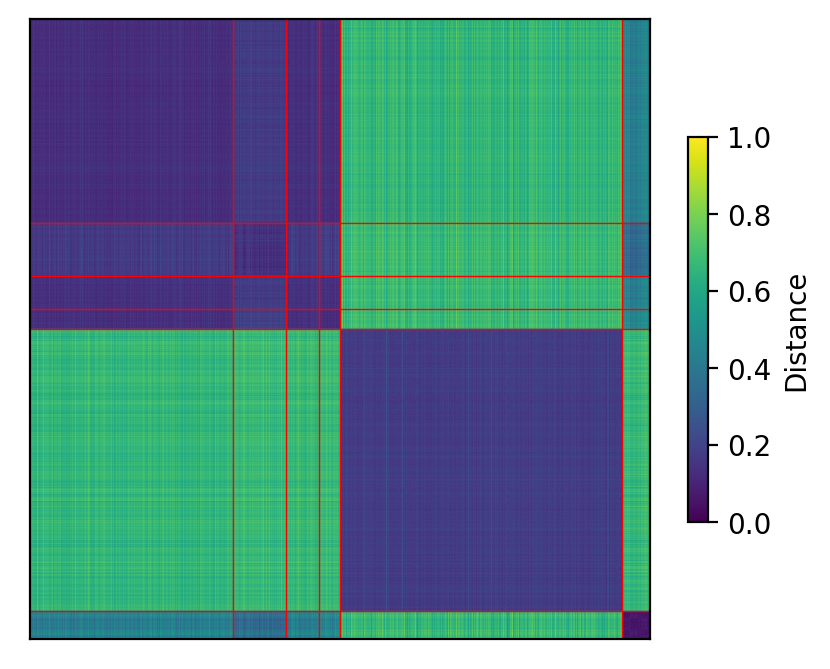

In [223]:
# analyze distances in UMAP space
metric = 'euclidean'
D = scipy.spatial.distance.pdist(embedding, metric=metric)
D = min_max(D)
D = scipy.spatial.distance.squareform(D)
D = pd.DataFrame(D, index=pdf.obs.index, 
                 columns=pdf.obs.index)

sorted_idx = pdf.obs.sort_values(by='group').index
group_labels = pdf.obs['group'].sort_values().values
label_switch_idx = np.where(group_labels[:-1] != group_labels[1:])[0]
group_labels_unique = np.unique(group_labels)

D = D[sorted_idx]
D = D.reindex(sorted_idx)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

plt.imshow(D)
plt.colorbar(shrink=0.5, label='Distance')
plt.xticks([], [])
plt.yticks([], [])

for i, idx_val in enumerate(label_switch_idx):
    print(group_labels_unique[i])
    plt.axvline(x=idx_val, c='r', lw=0.5)
    plt.axhline(y=idx_val, c='r', lw=0.5)

Text(0.5, 1.0, 'Mean Distance')

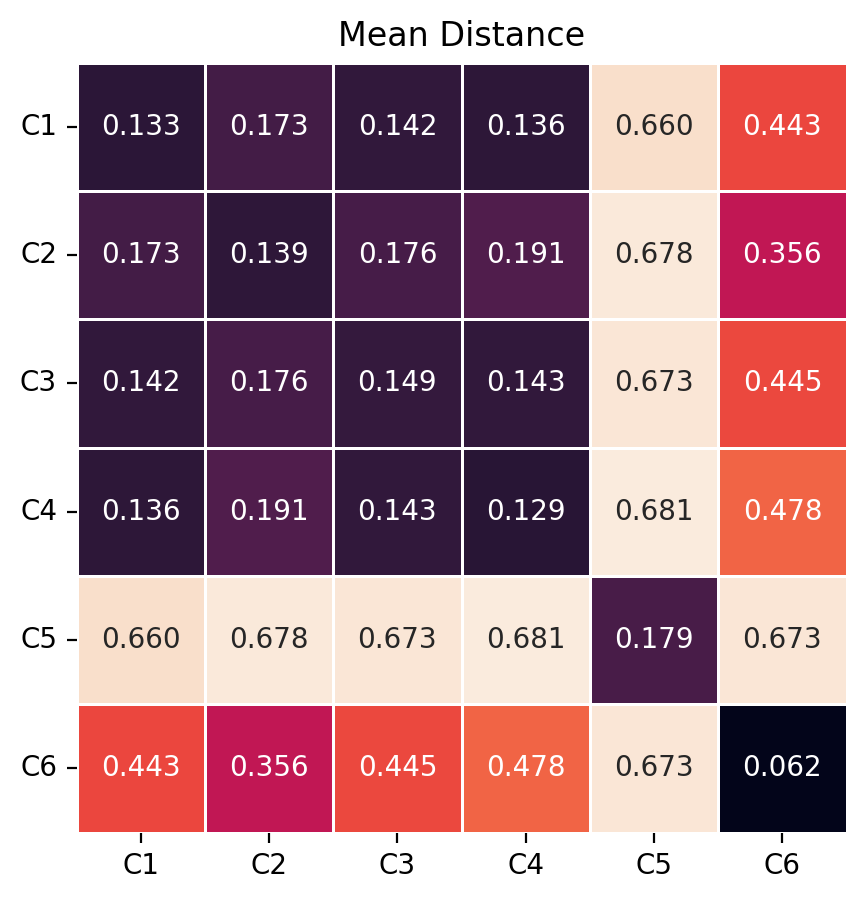

In [224]:
# average distances
res = []

for i_name, group_i in pdf.obs.groupby('group'):
    for j_name, group_j in pdf.obs.groupby('group'):
        i_idx = group_i.index
        j_idx = group_j.index

        mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())

        row = {
            'i_name' : i_name,
            'j_name' : j_name,
            'mean_dist' : mean_dist,
        }

        res.append(row)
        
res = pd.DataFrame(res)
res = pd.pivot_table(res, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(res, square=True,
            linewidth=0.5,
            annot=True,
            fmt=".3f",
            cbar=False)

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title("Mean Distance")

# Gene level plots

<AxesSubplot: xlabel='UMAP 1', ylabel='UMAP 2'>

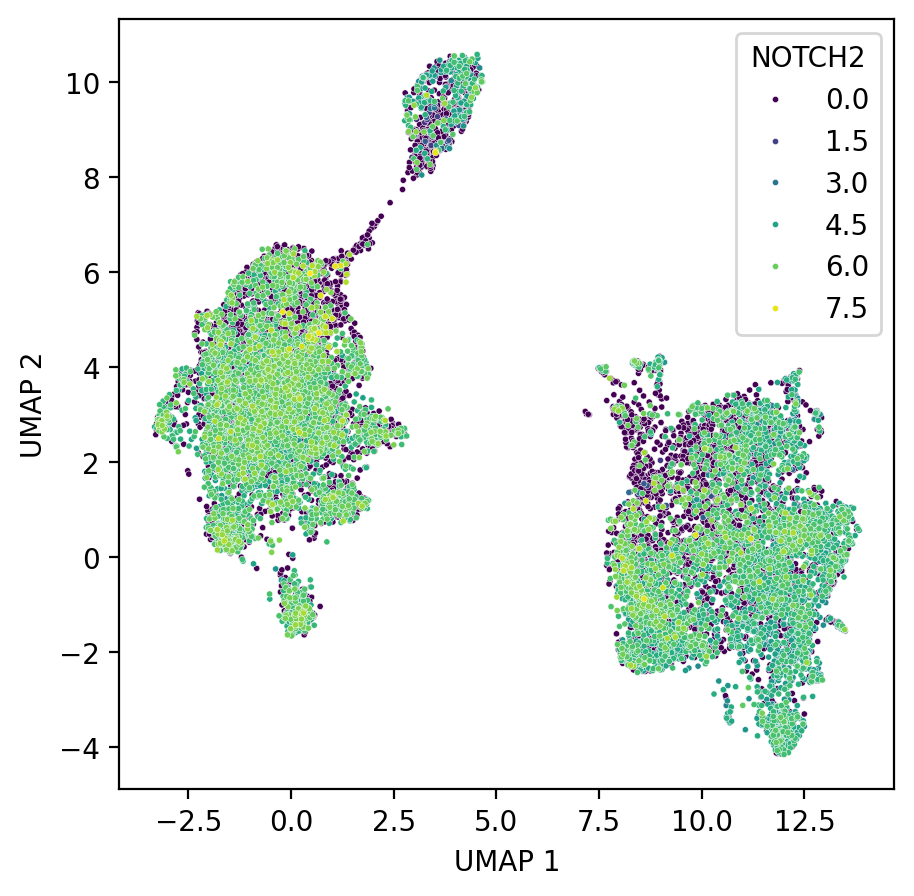

In [242]:
gene = 'NOTCH2'
pdx = pdf.obs.copy()
pdx[gene] = pdf[:, gene].to_df(layer='log_tpm')

pdx['UMAP 1'] = embedding[:, 0]
pdx['UMAP 2'] = embedding[:, 1]

order_idx = np.argsort(pdx[gene])

sns.scatterplot(data=pdx.iloc[order_idx], 
               x='UMAP 1',
               y='UMAP 2',
               palette='viridis',
               s=5,
               hue=gene)

AnnData object with n_obs × n_vars = 16968 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group', 'label'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

In [181]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)